In [139]:
import pandas as pd
import numpy as np
import numpy.random as r
import scipy.io as sio
import scipy.stats
import matplotlib.pyplot as plt
import random
from collections import Counter
import math
pi = np.pi

## Q3

In [3]:
def Quantize(x, x_median):
    for i in np.arange(x.shape[0]):
        for j in np.arange(x.shape[1]):
            if x[i, j] <= x_median[j]:
                x[i, j] = 1
            else:
                x[i, j] = 2
    return x

def CalculateLikelihood(spam_ham, obs, lld_spam_1, lld_spam_2, lld_ham_1, lld_ham_2):
    prob_product = 1
    for i in np.arange(len(obs)):
        if ((obs[i] == 1.0) & (spam_ham == 1)):
            prob_product *= lld_spam_1[i]
        elif ((obs[i] == 2.0) & (spam_ham == 1)):
            prob_product *= lld_spam_2[i]
        elif ((obs[i] == 1.0) & (spam_ham == 0)):
            prob_product *= lld_ham_1[i]
        else:
            prob_product *= lld_ham_2[i]
    return prob_product

def NaiveBayesClassifier(obs, lld_spam_1, lld_spam_2, lld_ham_1, lld_ham_2, prior):
    # Calculate the posterior probabilities of spam
    posterior_spam = CalculateLikelihood(1, obs, lld_spam_1, lld_spam_2, lld_ham_1, lld_ham_2) * prior[0]
    # Calculate the posterior probabilities of ham
    posterior_ham = CalculateLikelihood(0, obs, lld_spam_1, lld_spam_2, lld_ham_1, lld_ham_2) * prior[1] 
    if posterior_ham >= posterior_spam:
        return 0
    else:
        return 1

In [4]:
# load the training data 
x_train = np.load("spam_train_features.npy")
y_train = np.load("spam_train_labels.npy")

# load the test data 
x_test = np.load("spam_test_features.npy")
y_test = np.load("spam_test_labels.npy")

x_train = Quantize(x_train, np.median(x_train,axis=0))
x_test = Quantize(x_test, np.median(x_test,axis=0))

 # Split the training data. One has only spams, the other has only hams.
spam_indices = y_train == 1
x_train_spam = x_train[spam_indices,:]
x_train_ham = x_train[~spam_indices,:]
y_train_spam = y_train[spam_indices]
y_train_ham = y_train[~spam_indices]

In [5]:
# Get Prior Probabilities
prior_spam = Counter(y_train)[1.0] / len(y_train)
prior_ham = Counter(y_train)[0.0] / len(y_train)

In [6]:
lld_spam_1 = []
lld_spam_2 = []
lld_ham_1 = []
lld_ham_2 = []
# Get the likelihood of 1 and 2 for each class for each column
for j in range(x_train_spam.shape[1]):
    lld_spam_1.append(sum(x_train_spam[:,j] == 1.0) / x_train_spam.shape[0])
    lld_spam_2.append(sum(x_train_spam[:,j] == 2.0) / x_train_spam.shape[0])

for j in range(x_train_ham.shape[1]):
    lld_ham_1.append(sum(x_train_ham[:,j] == 1.0) / x_train_ham.shape[0])
    lld_ham_2.append(sum(x_train_ham[:,j] == 2.0) / x_train_ham.shape[0])

In [7]:
pred = []
for i in range(x_test.shape[0]):
    pred.append(NaiveBayesClassifier(x_test[i,:], lld_spam_1, lld_spam_2, lld_ham_1, lld_ham_2, [prior_spam, prior_ham]))

In [8]:
print("Test error: " + str(1 - sum(pred == y_test) / len(y_test)))

Test error: 0.030000000000000027


## Q4

In [9]:
def multivariate_gaussian(x, mean, sigma):
    d = sigma.shape[0]
    quadratic = (x-mean).T.dot(np.linalg.inv(sigma)).dot(x-mean)
    return 1/(2*pi)**(d/2)*1/np.sqrt(np.linalg.det(sigma)) * np.exp(-1/2*quadratic)

def marginal_distribution(mean, sigma, indice):
    index = np.tile(0,mean.shape[0])
    for i in indice:
        index[i] = 1 
    index_sig = index.reshape((1,-1))
    marginal_mean = np.ma.array(mean, mask= np.subtract(1, index)).compressed()
    marginal_sigma = np.ma.array(sigma, mask = np.subtract(1,index_sig.T.dot(index_sig))).compressed().reshape((sum(index),sum(index)))
    return marginal_mean, marginal_sigma

def covaraince(sigma, indice_U, indice_V):
    index_matrix = np.zeros((sigma.shape[0],sigma.shape[0]))
    index_matrix[:,indice_U]=1
    index_matrix[indice_V,:]=1
    UV_sigma = np.ma.array(sigma, mask = index_matrix).compressed().reshape((len(indice_U),len(indice_V)))
    return UV_sigma

def conditional_distribution(mean, sigma, indice_U, indice_V, V):
    V_mean, V_sigma = marginal_distribution(mean, sigma, indice_V)
    U_mean, U_sigma = marginal_distribution(mean, sigma, indice_U)
    UV_sigma = covaraince(sigma, indice_U, indice_V)
    U_conditional_mean = U_mean + UV_sigma.dot(np.linalg.inv(V_sigma)).dot(V-V_mean)
    U_conditional_sigma = U_sigma - UV_sigma.dot(np.linalg.inv(V_sigma)).dot(UV_sigma.T)
    return U_conditional_mean, U_conditional_sigma

In [10]:
mean = np.array([0,0]).reshape((2,1))
sigma = np.array([1,0.5,0.5,1]).reshape((2,2))
indice = [0]
marginal_mean, marginal_sigma = marginal_distribution(mean, sigma, indice)
X = np.arange(-2,2,0.1)
pdf = []
for x in X:
    pdf.append(multivariate_gaussian(x, marginal_mean, marginal_sigma))

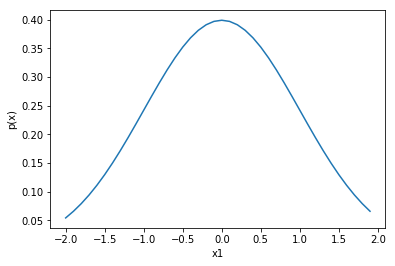

In [11]:
plt.plot(X,pdf)
plt.xlabel('x1')
plt.ylabel('p(x)')
plt.show()

In [12]:
mean = np.array([0.5,0,-0.5,0]).reshape((4,1))
sigma = np.array([1,0.5,0,0,0.5,1,0,1.5,0,0,2.0,0,0,1.5,0,4]).reshape((4,4))
V = np.array([0.1,-0.2])
indice_U = [0,3]
indice_V = [1,2]
U_conditional_mean, U_conditional_sigma = conditional_distribution(mean, sigma, indice_U, indice_V, V)

In [16]:
U_conditional_mean, U_conditional_sigma

(array([0.55, 0.15]), array([[ 0.75, -0.75],
        [-0.75,  1.75]]))

In [53]:
x1 = np.arange(-2,2,0.1)
x4 = np.arange(-2,2,0.1)
con_pdf = np.zeros((len(x1),len(x4)))
for i in range(len(x1)):
    for j in range(len(x4)):
        x = np.array([x1[i],x4[j]]).reshape((2,1))
        u_pdf = multivariate_gaussian(x, U_conditional_mean.reshape((2,1)), U_conditional_sigma.reshape((2,2))).reshape(-1)
        con_pdf[j][i] = u_pdf[0]

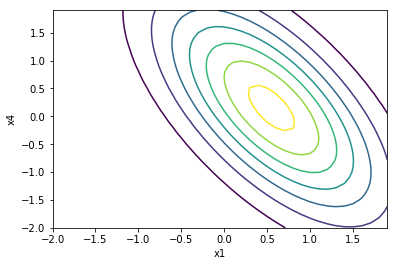

In [54]:
plt.contour(x1,x4,con_pdf)
plt.xlabel('x1')
plt.ylabel('x4')
plt.show()

## Q5

In [94]:
np.random.seed(0)

In [212]:
def Kernel(x, sigma):
    d  = x.shape[0]
    kernel =  np.zeros((d,d))
    for i in range(d):
        for j in range(d):
            kernel[i][j] = np.exp(-1/(2*sigma**2) * (x[j] - x[i])**2)
    return kernel

def GaussianProcess(x , sigma):
    var = Kernel(x, sigma)
    y = np.random.multivariate_normal(np.zeros((100,)), var)
    return y

def multivariate_gaussian(x, mean, sigma):
    d = sigma.shape[0]
    quadratic = (x-mean).T.dot(np.linalg.inv(sigma)).dot(x-mean)
    return 1/(2*pi)**(d/2)*1/np.sqrt(np.linalg.det(sigma)) * np.exp(-1/2*quadratic)

def marginal_distribution(mean, sigma, indice):
    index = np.tile(0,mean.shape[0])
    for i in indice:
        index[i] = 1 
    index_sig = index.reshape((1,-1))
    marginal_mean = np.ma.array(mean, mask= np.subtract(1, index)).compressed()
    marginal_sigma = np.ma.array(sigma, mask = np.subtract(1,index_sig.T.dot(index_sig))).compressed().reshape((sum(index),sum(index)))
    return marginal_mean, marginal_sigma

def covaraince(sigma, indice_U, indice_V):
    index_matrix = np.zeros((sigma.shape[0],sigma.shape[0]))
    index_matrix[:,indice_U]=1
    index_matrix[indice_V,:]=1
    UV_sigma = np.ma.array(sigma, mask = index_matrix).compressed().reshape((len(indice_U),len(indice_V)))
    return UV_sigma

def conditional_distribution(mean, sigma, indice_U, indice_V, V):
    V_mean, V_sigma = marginal_distribution(mean, sigma, indice_V)
    U_mean, U_sigma = marginal_distribution(mean, sigma, indice_U)
    UV_sigma = covaraince(sigma, indice_U, indice_V)
    U_conditional_mean = U_mean + UV_sigma.dot(np.linalg.inv(V_sigma)).dot(V-V_mean)
    U_conditional_sigma = U_sigma - UV_sigma.dot(np.linalg.inv(V_sigma)).dot(UV_sigma.T)
    return U_conditional_mean, U_conditional_sigma

In [213]:
X = np.arange(-5,5,0.1)
sigma_list = [0.3, 0.5, 1.0]

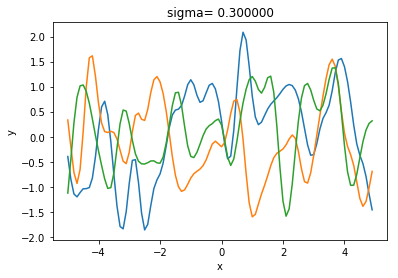

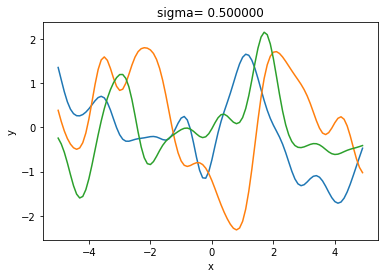

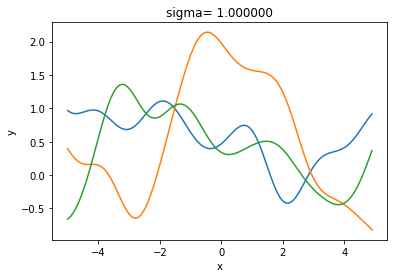

In [214]:
for i in range(3):
    y1 = GaussianProcess(X , sigma_list[i])
    y2 = GaussianProcess(X , sigma_list[i])
    y3 = GaussianProcess(X , sigma_list[i])
    plt.plot(X,y1)
    plt.plot(X,y2)
    plt.plot(X,y3)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('sigma= %f' %sigma_list[i])
    plt.show()

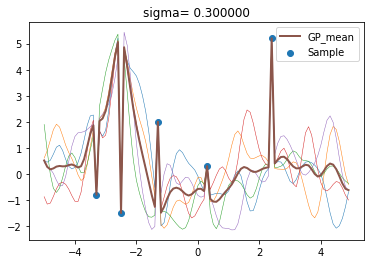

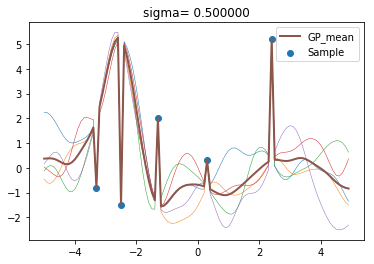

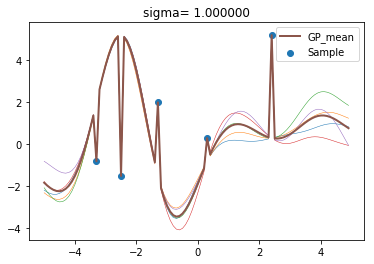

In [215]:
x_s = np.array([-1.3, 2.4, -2.5, -3.3, 0.3])
y_s = np.array([2, 5.2, -1.5, -0.8, 0.3])
indice_V = np.array([37,74,25,17,53])
indice_U = np.delete(np.arange(0,100,1) , indice_V)
for i in range(3):
    var = Kernel(X, sigma_list[i])
    #print(var.shape)
    conditional_mean, conditional_sigma = conditional_distribution(np.zeros((100,1)), var, list(indice_U), list(indice_V), y_s)
    #print(conditional_mean.shape, conditional_sigma.shape)
    
    #y posterior
    new_x = X[[i for i in range(len(X)) if i not in indice_V]]
    y1 = np.random.multivariate_normal(conditional_mean, conditional_sigma)
    y2 = np.random.multivariate_normal(conditional_mean, conditional_sigma)
    y3 = np.random.multivariate_normal(conditional_mean, conditional_sigma)
    y4 = np.random.multivariate_normal(conditional_mean, conditional_sigma)
    y5 = np.random.multivariate_normal(conditional_mean, conditional_sigma)
    
    y_mean = np.array([y1,y2,y3,y4,y5]).mean(axis = 0)
    
    #sort x and y
    X_all = np.append(new_x,X[indice_V])
    arg = np.argsort(X_all)
    
    for y_ax in [y1,y2,y3,y4,y5]:
        p_y = np.append(y_ax,  y_s)
        plt.plot(X_all[arg], p_y[arg], linewidth= 0.5)
    plt.scatter(x_s,y_s, label = 'Sample')
    p_y = np.append(y_mean,  y_s)
    plt.plot(X_all[arg], p_y[arg], linewidth= 2, label = 'GP_mean')
    plt.legend()
    plt.title('sigma= %f' %sigma_list[i])
    plt.show()
    
    

## Q6

In [140]:
def LDA(mu0, mu1, cov,X):
    return (((mu1-mu0).T).dot(np.linalg.inv(cov)).dot(X)) - 1/2*((mu1.T).dot(np.linalg.inv(cov)).dot(mu1)-(mu0.T).dot(np.linalg.inv(cov)).dot(mu0))

def QDA(mu0, mu1, cov0, cov1, X):
    term1 = 1/2*(((X-mu0).T).dot(np.linalg.inv(cov0)).dot((X-mu0))-((X-mu1).T).dot(np.linalg.inv(cov1)).dot((X-mu1)))
    #print(term1.shape)
    term2 = 1/2*math.log(np.linalg.det(cov0)/np.linalg.det(cov1))
    return term1+term2

In [141]:
from sklearn.datasets import load_iris
iris=load_iris()
# You have two features and two classifications
data_0, data_1 = iris.data[:,1:3][:50], iris.data[:,1:3][50:100]
data = np.concatenate((data_0,data_1),axis=0)

In [142]:
mu0 = np.mean(data_0,axis=0).reshape((2,1))
mu1 = np.mean(data_1,axis=0).reshape((2,1))
cov = np.cov(data,rowvar=False).reshape((2,2))
cov0 = np.cov(data_0,rowvar=False).reshape((2,2))
cov1 = np.cov(data_1,rowvar=False).reshape((2,2))

In [143]:
LDA_score = LDA(mu0, mu1, cov, data.T)
LDA_result = np.array(LDA_score>0)
QDA_score = QDA(mu0, mu1, cov0, cov1, data.T)
QDA_result = np.array(np.diag(QDA_score)>0)

In [202]:
w = (mu1-mu0).T.dot(np.linalg.inv(cov))
b = -1/2*((mu1.T).dot(np.linalg.inv(cov)).dot(mu1)-(mu0.T).dot(np.linalg.inv(cov)).dot(mu0))[0][0]
x = np.arange(0,6,0.1)
y = (w[0,0]*x+b)/(-w[0,1])

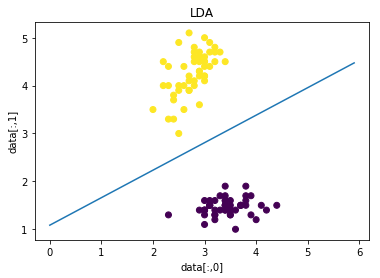

In [206]:
plt.scatter(x=data[:,0],y=data[:,1],c= LDA_result.reshape(-1))
plt.plot(x,y)
plt.xlabel('data[:,0]')
plt.ylabel('data[:,1]')
plt.title('LDA')
plt.show()

In [208]:
from sympy import plot_implicit, cos, sin, symbols, Eq, And

In [248]:
x, y = symbols('x y')
X = np.array([x,y]).reshape((2,1))
diff1 = np.linalg.inv(cov0) - np.linalg.inv(cov1)
diff2 = np.linalg.inv(cov0).dot(mu0) -  np.linalg.inv(cov1).dot(mu1)
threshold = 1/2*((mu1.T).dot(np.linalg.inv(cov)).dot(mu1)-(mu0.T).dot(np.linalg.inv(cov)).dot(mu0))[0][0] + \
1/2*np.log(np.linalg.det(cov1)/np.linalg.det(cov0))
expr = 1/2*(X.T.dot(diff1).dot(X)) - X.T.dot(diff2) - threshold

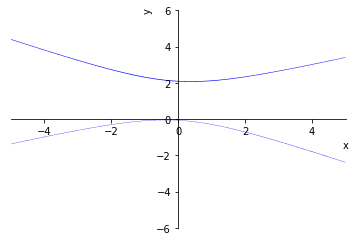

In [264]:
plt2 = plot_implicit(Eq(expr[0,0],0),(x,-5,5), (y,-6,6))
plt2._backend.ax.scatter(data_0[:,0],data_0[:,1],label='data_0')
plt2._backend.ax.scatter(data_1[:,0],data_1[:,1],label='data_1')
plt2._backend.save('plt2.png')